In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.nn import MSELoss
from torch.optim import Adam
import torch.nn.functional as nnf
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import Dataset

from torchvision.transforms import transforms, Resize
import torchvision.datasets as datasets

from torchinfo import summary

from piq import psnr, LPIPS
lpips = LPIPS()

from utils.datasets import CIFAR_SR

from tqdm import tqdm

import matplotlib.pyplot as plt

from models.prediction.HVAE import HVAE

from utils.metrics import validation_scores

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [2]:
path = "CIFAR_HVAE_divers6.pth"

x_dim = 32

scale_factor = 2
x_inp_dim  = int(x_dim / scale_factor)


# lr = 1e-3
epochs = 150
batch_size = 1024
batch_size_test = 128

train_dataset = CIFAR_SR(split="train", scale_factor=scale_factor)
test_dataset = CIFAR_SR(split="test", scale_factor=scale_factor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [3]:
in_channels = 3
channels = [32, 64, 128, 256]
latent_dims = [32, 32, 32]

model = HVAE(in_channels=in_channels, channels=channels, latent_dims=latent_dims, base_width=x_inp_dim).to(DEVICE)
summary(model, input_size=(1,in_channels, x_inp_dim, x_inp_dim))

Layer (type:depth-idx)                   Output Shape              Param #
HVAE                                     [1, 3, 32, 32]            --
├─HVAELREncoder: 1-1                     [1, 32]                   --
│    └─Conv2d: 2-1                       [1, 32, 16, 16]           128
│    └─Conv2d: 2-2                       [1, 64, 8, 8]             32,832
│    └─Conv2d: 2-3                       [1, 128, 4, 4]            131,200
│    └─Linear: 2-4                       [1, 32]                   65,568
│    └─Linear: 2-5                       [1, 32]                   65,568
│    └─Linear: 2-6                       [1, 32]                   131,104
│    └─Linear: 2-7                       [1, 32]                   131,104
│    └─Linear: 2-8                       [1, 32]                   262,176
│    └─Linear: 2-9                       [1, 32]                   262,176
├─Linear: 1-2                            [1, 32]                   1,056
├─Linear: 1-3                            [1,

In [4]:
def loss_function(x, x_hat, latents):
    reproduction_loss = MSELoss(reduction='sum')(x_hat, x)
    KLD = 0
    for mu, logvar in latents:
        KLD += -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (reproduction_loss + KLD) / x.size(0)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=12, gamma=0.9)

In [5]:
def diversity_score(model, dataset):
    model.eval()
    HR, LR = test_dataset.get_samples(1000)
    mse_diversity_val = 0
    lpips_diversity_val = 0
    n_iterations = 32
    n_samples = 8
    for i in range(n_iterations):
        LR_input = LR[i].unsqueeze(0)
        LR_input = LR_input.repeat(n_samples, 1, 1, 1)
        HR_reference = HR[i].unsqueeze(0)
        HR_reference = HR_reference.repeat(n_samples, 1, 1, 1)
        SR = model.sample(LR_input)
        # torch.cdist(x1, x2, p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')?
        for sample in SR:
            SR_ref = sample.unsqueeze(0)
            SR_ref = SR_ref.repeat(n_samples, 1, 1, 1)
            mse_diversity_val += nnf.mse_loss(SR_ref, SR, reduction='mean').item()
            lpips_diversity_val += lpips(SR_ref, SR).item()
    mse_diversity_val /= n_iterations*n_samples
    lpips_diversity_val /= n_iterations*n_samples
    return mse_diversity_val, lpips_diversity_val

def consitency_score(model, dataset):
    model.eval()
    HR, LR = dataset.get_samples(1000)
    SR = model(LR)[0]
    SR_downsampled = Resize((LR.size(2), LR.size(3)))(SR)
    SR_downsampled = SR_downsampled.clamp(0, 1)

    psnr_consistency_val = psnr(LR, SR_downsampled, data_range=1.0).item()
    return psnr_consistency_val

In [6]:
model_loss = []
diversity_psnr_scores = []
diversity_lpips_scores = []
consistency_scores = []

In [21]:
print("Start training VAE...")

for epoch in range(epochs):
    model.train()
    overall_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        HR, LR = batch

        SR, latents = model(LR)
        # mean, log_var = latents[0]
        loss = loss_function(HR, SR, latents)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("\tEpoch", epoch, "complete!", "\tAverage Loss: ", overall_loss)
        mse_diversity_val, lpips_diversity_val = diversity_score(model, test_dataset)
        psnr_consistency_val = consitency_score(model, test_dataset)
        diversity_psnr_scores.append(mse_diversity_val)
        diversity_lpips_scores.append(lpips_diversity_val)
        consistency_scores.append(psnr_consistency_val)
        print("Diversity MSE: ", mse_diversity_val, "\tDiversity LPIPS: ", lpips_diversity_val, "\tConsistency PSNR: ", psnr_consistency_val)

    model_loss.append(overall_loss)
    scheduler.step()

print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss)
print("Finish!!")

Start training VAE...
	Epoch 0 complete! 	Average Loss:  2955.262306213379
Diversity MSE:  0.0038828189863124862 	Diversity LPIPS:  0.18557139980839565 	Consistency PSNR:  21.877853393554688
	Epoch 10 complete! 	Average Loss:  2951.7662467956543
Diversity MSE:  0.003914538433491543 	Diversity LPIPS:  0.1901133655628655 	Consistency PSNR:  21.88758659362793
	Epoch 20 complete! 	Average Loss:  2949.818977355957
Diversity MSE:  0.003880366490648157 	Diversity LPIPS:  0.18476585976895876 	Consistency PSNR:  21.87565040588379
	Epoch 30 complete! 	Average Loss:  2947.5362396240234
Diversity MSE:  0.00403185049071908 	Diversity LPIPS:  0.19154304591938853 	Consistency PSNR:  21.87540626525879
	Epoch 40 complete! 	Average Loss:  2947.318820953369
Diversity MSE:  0.004024231873700046 	Diversity LPIPS:  0.1844539529120084 	Consistency PSNR:  21.8638916015625
	Epoch 50 complete! 	Average Loss:  2944.0683403015137
Diversity MSE:  0.0040128818627636065 	Diversity LPIPS:  0.18903945860802196 	Consis

[]

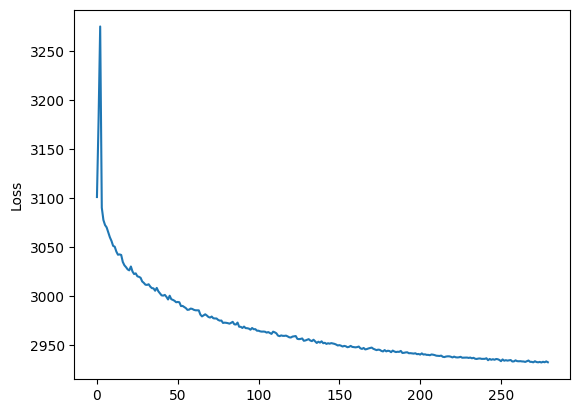

In [22]:
plt.plot(model_loss[20:])

plt.ylabel('Loss')
# plt.yscale('log')
plt.plot()

[]

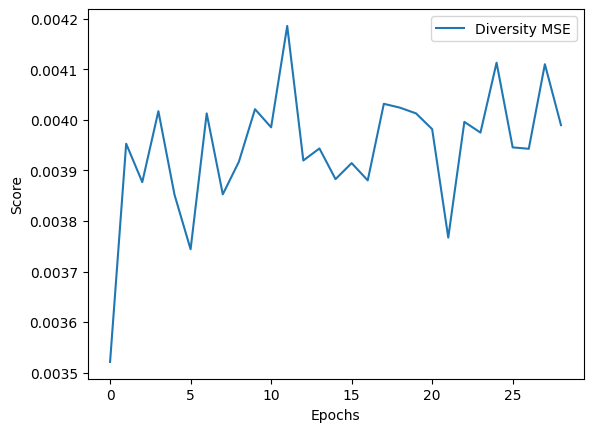

In [26]:
plt.plot(diversity_psnr_scores[1:])
# plt.plot(diversity_lpips_scores[1:])
# plt.plot(consistency_scores[1:])
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend(['Diversity MSE', 'Diversity LPIPS', 'Consistency PSNR'])
plt.plot()

In [27]:
HR, LR = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [10]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

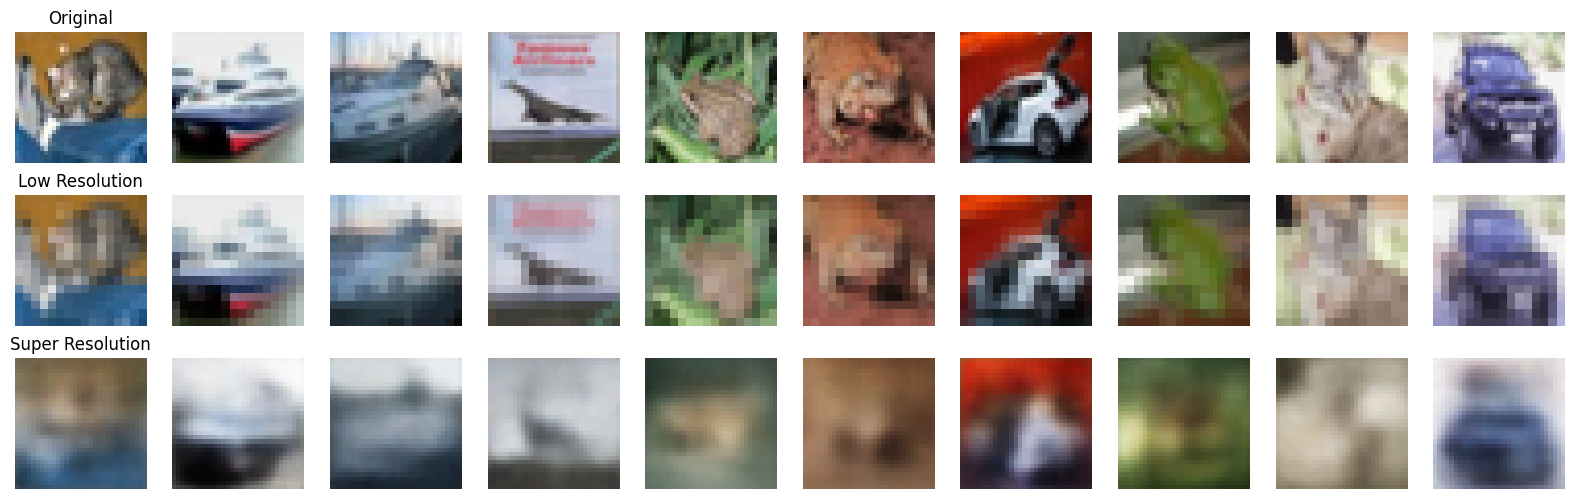

In [28]:
show_image(HR, LR, SR, 10)

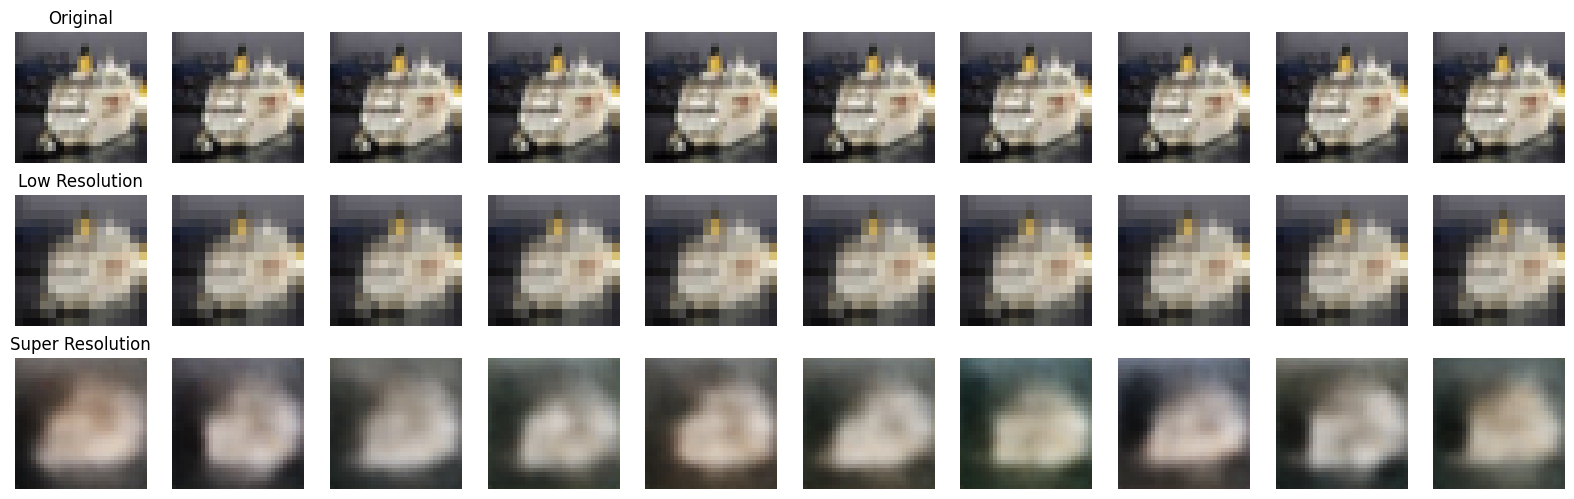

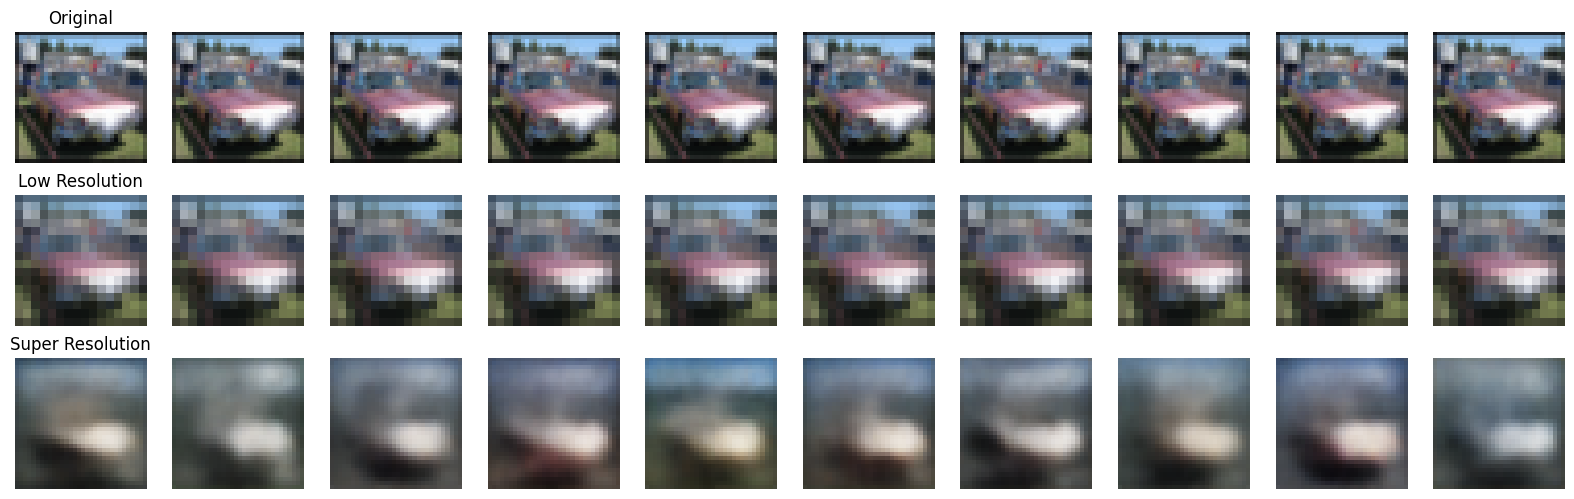

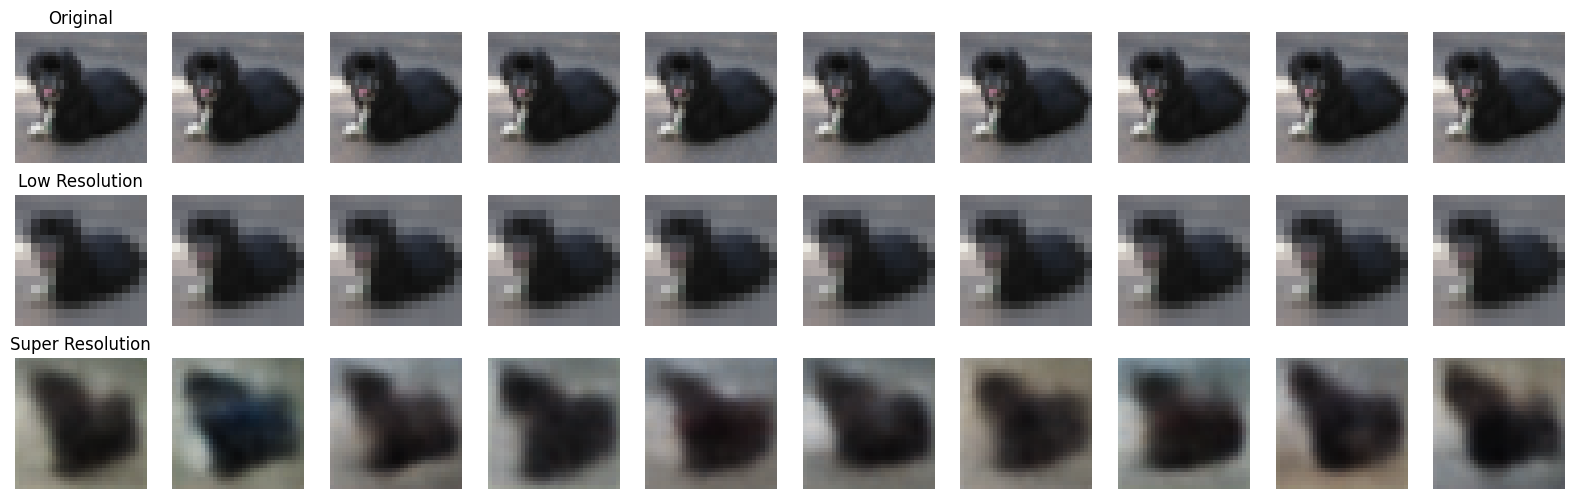

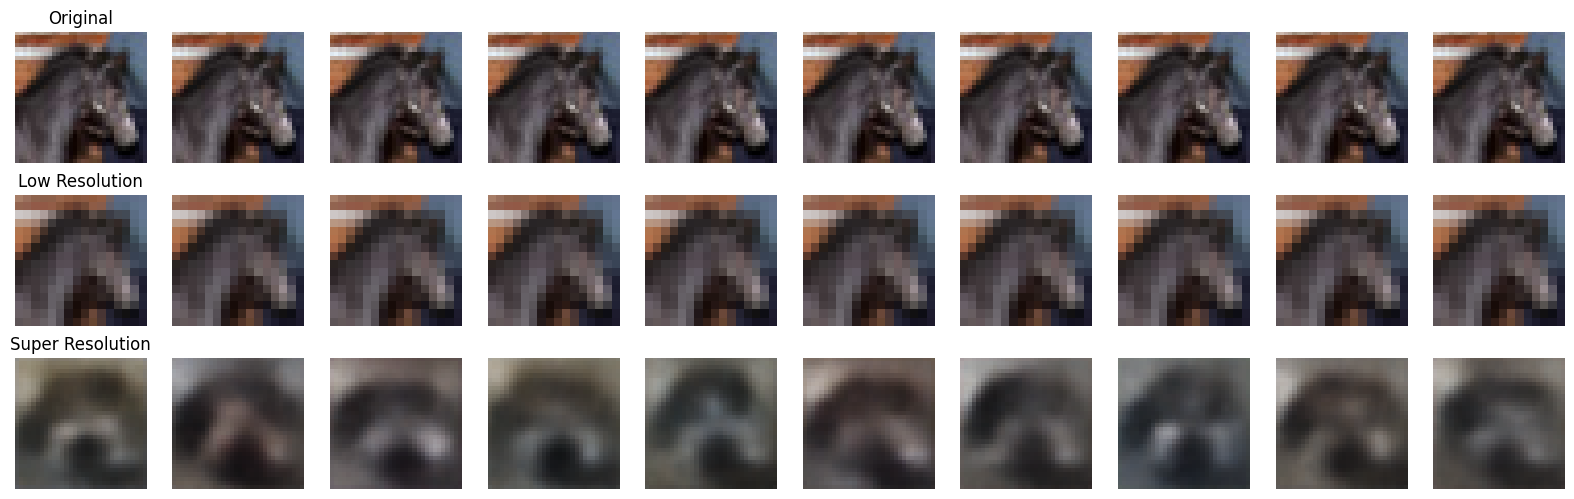

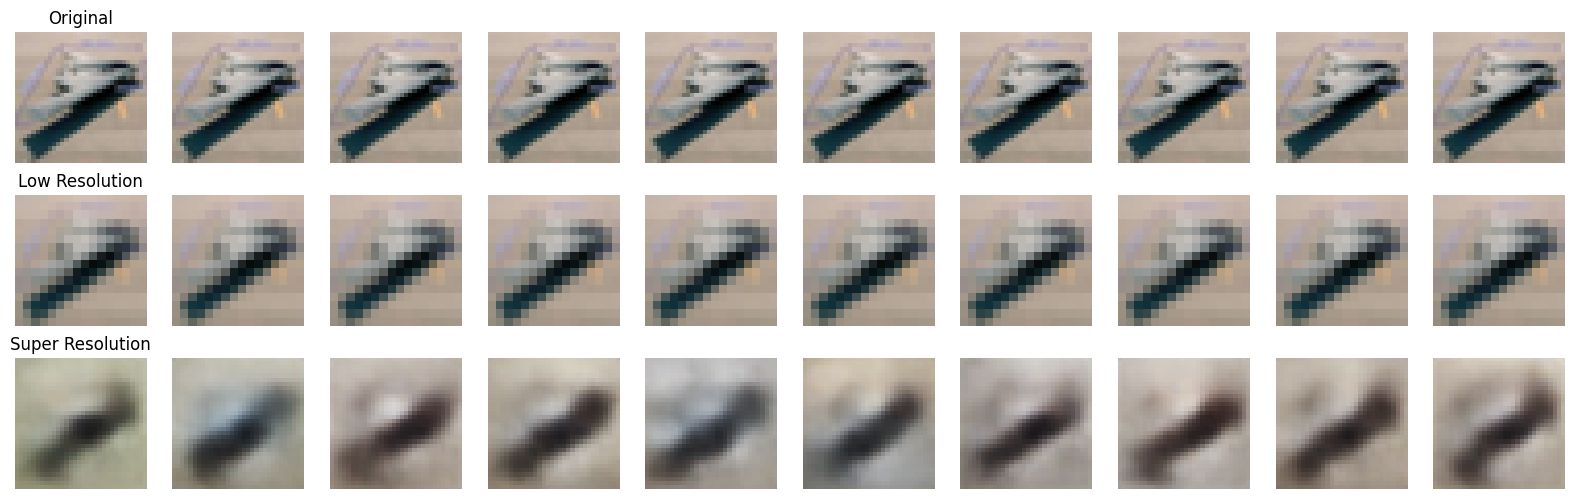

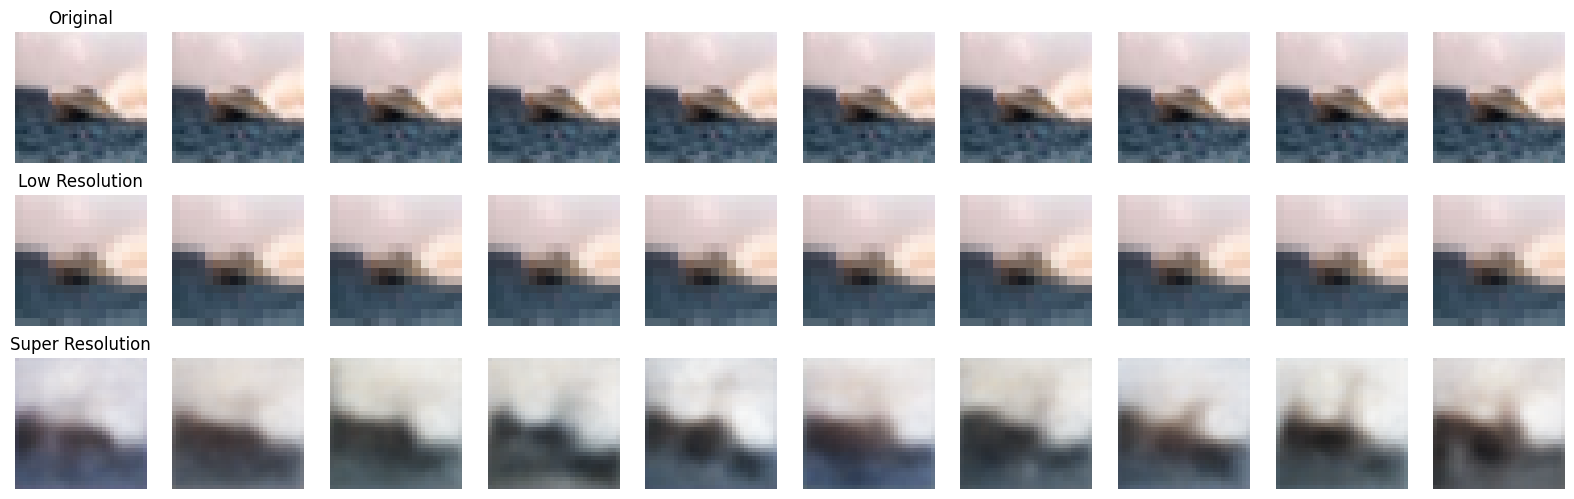

In [29]:
n_samp = 6
offset = 260

for i in range(offset, offset+n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [30]:
# save model
torch.save(model.state_dict(), path)

In [14]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [31]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 0.013196611776947975
Perceptual: 6.214354038238525
PSNR: 19.20064926147461
SSIM: 0.4756482243537903
LPIPS: 0.5141644477844238
BRISQUE: 82.77307891845703
PSNR Consistency: 21.96283721923828
MSE Diversity: 0.0039048351982273743
LPIPS Diversity: 0.18864214167115279
